In [1]:
# %load /Users/xichen/Library/Mobile\ Documents/com~apple~CloudDocs/computer_bootstrap/my_imports.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.io import mmread
import matplotlib.pyplot as plt
from collections import Counter

Kelly = ['#af2337', '#ecc342', '#2967a0', '#2f3c28', '#96b437',
         '#da93ab', '#e58932', '#80598f', '#7e331f', '#3b855a',
         '#c0b286', '#a9c9ed', '#ec977f', '#848482', '#604628',
         '#d26034', '#a64c6b', '#dbd245', '#eba83b', '#5d5092',
         '#222222', '#f2f3f4']

GreenArmytage = ['#e3a7fa', '#3575d5', '#8d4418', '#440b59', '#191919', '#285a35',
                 '#6aca5b', '#f6cda0', '#808080', '#b1fcbb', '#8c7c26', '#a8ca3f',
                 '#af2785', '#13347b', '#51a12f', '#f1acbb', '#4b651a', '#e73329',
                 '#8deef0', '#48978f', '#e7fd7d', '#0c1ff5', '#8a1a11', '#fffe92',
                 '#f9e14c', '#e95d2a']

Chromsomes = ['#fefb57', '#c15662', '#b3bff5', '#75f9f0', '#ea8a33',
              '#9e5dca', '#946e6b', '#f3c985', '#f0feee', '#afe347',
              '#5dc5e5', '#e73ff0', '#e23022', '#ed7fc5', '#4f8283',
              '#af35f5', '#49a9f6', '#ea3584', '#94f8b8', '#4d6df6',
              '#eafdad', '#f6c6ec', '#5d8841', '#74f973']

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=Kelly)
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.markerscale'] = 1
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['figure.dpi'] = 100

# ATAC

In [2]:
cells = [i.strip() for i in open('ATAC/full_analysis/outs/filtered_mtx/barcodes.tsv')]

In [4]:
hs_atac = pd.read_csv('ATAC/full_analysis/outs/per_cell_barcode_total_fragment_count_GRCh38.tsv',
                      header=None, names=['count_hs', 'cb'], index_col = 'cb', sep='\t')
mm_atac = pd.read_csv('ATAC/full_analysis/outs/per_cell_barcode_total_fragment_count_mm10.tsv',
                      header=None, names=['count_mm', 'cb'], index_col = 'cb', sep='\t')
df_atac = pd.concat([hs_atac, mm_atac], axis=1)
df_atac = df_atac.loc[cells,]
df_atac['total'] = df_atac['count_hs'] + df_atac['count_mm']

/home/xichen/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xichen/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


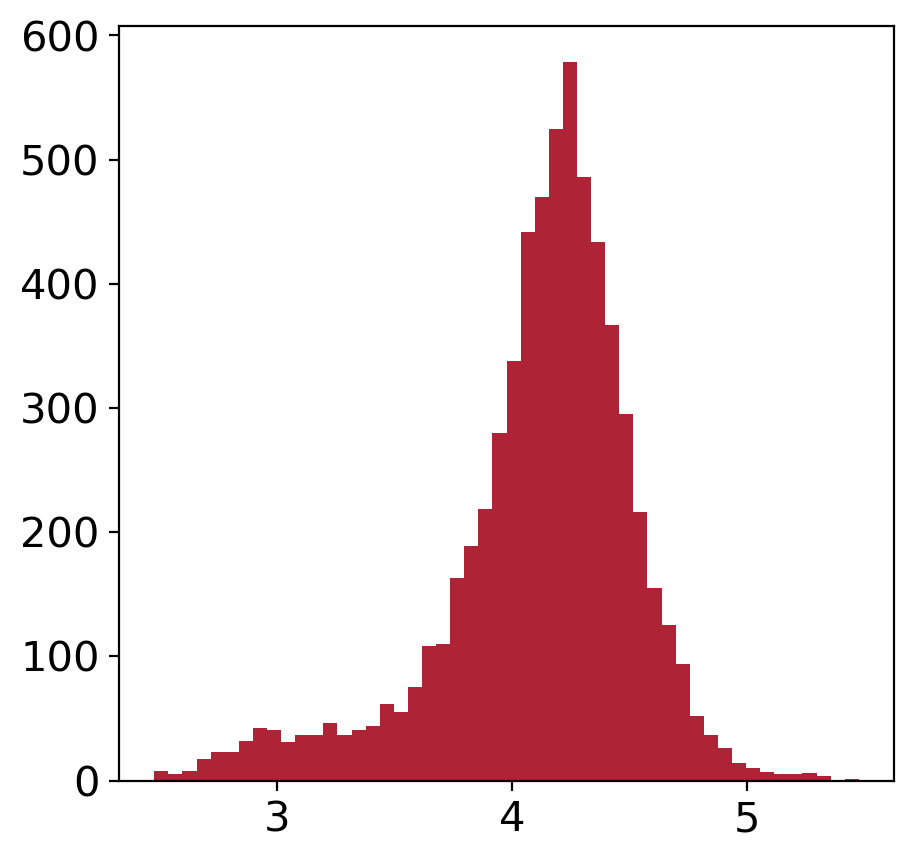

In [5]:
plt.figure(figsize=(5,5))
plt.hist(np.log10(df_atac['total']), 50)
plt.show()

In [6]:
df_atac['species'] = 0
df_atac.loc[df_atac['count_hs']/df_atac['total'] > 0.9, 'species'] = 'Human'
df_atac.loc[df_atac['count_mm']/df_atac['total'] > 0.9, 'species'] = 'Mouse'
df_atac.loc[df_atac.query('total < 1000').index, 'species'] = 'Low yield'
df_atac.replace({'species' : {0 : 'Mix'}}, inplace=True)

In [7]:
df_atac.species.value_counts()

Mouse        3056
Human        2653
Mix           533
Low yield     187
Name: species, dtype: int64

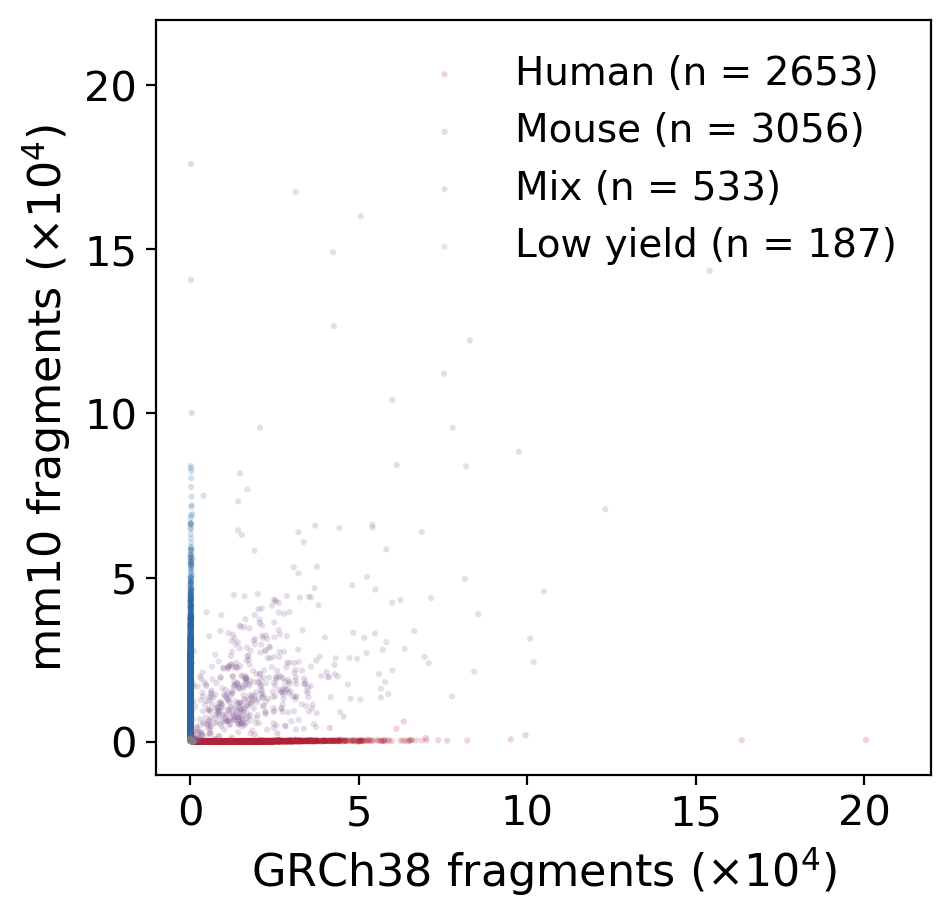

In [9]:
plt.figure(figsize=(5,5))
for sp, c in zip(['Human', 'Mouse', 'Mix', 'Low yield'], ['#af2337', '#2967a0', '#80598f', '#848482']):
    plt.scatter(df_atac.query('species == @sp')['count_hs'], df_atac.query('species == @sp')['count_mm'],
                c=c, ec=None, s=5, label='%s (n = %s)' % (sp, df_atac.species.value_counts()[sp]), alpha=.2)
plt.legend(frameon=False, markerscale=1)
plt.xlim(-10000, 220000)
plt.ylim(-10000, 220000)
plt.xticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.yticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.xlabel(r'GRCh38 fragments ($\times 10^4$)')
plt.ylabel(r'mm10 fragments ($\times 10^4$)')
plt.savefig('barnyard_droplet_atac_full.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [10]:
count = mmread('ATAC/full_analysis/outs/filtered_mtx/matrix.mtx')
cols = [i.strip() for i in open('ATAC/full_analysis/outs/filtered_mtx/barcodes.tsv')]

sc_count = pd.DataFrame(data=count.toarray(),
                        columns=cols)

In [11]:
nih = sc_count.loc[:, df.query('species == "Mouse"').index]
hek = sc_count.loc[:, df.query('species == "Human"').index]

In [12]:
!mkdir -p ATAC/full_analysis/outs/HEK293T
!mkdir -p ATAC/full_analysis/outs/NIH3T3

for cm, ct in zip([hek, nih], ['HEK293T', 'NIH3T3']):
    metrics = pd.DataFrame(data = cm.sum(0), columns = ['nCounts'])
    metrics['nFeatures'] = (cm > 0).sum(0)
    metrics.to_csv('ATAC/full_analysis/outs/%s/metrics.csv' % ct, index_label='cell')

# RNA

In [11]:
cells = [i.strip() for i in open('RNA/full_analysis/outs/Solo.out/Gene/filtered/barcodes.tsv')]

In [12]:
hs_rna = pd.read_csv('RNA/full_analysis/outs/per_cell_barcode_total_read_count_GRCh38.tsv',
                     header=None, names=['count_hs', 'cb'], index_col='cb', sep='\t')
mm_rna = pd.read_csv('RNA/full_analysis/outs/per_cell_barcode_total_read_count_mm10.tsv',
                     header=None, names=['count_mm', 'cb'], index_col='cb', sep='\t')
df_rna = pd.concat([hs_rna, mm_rna], axis=1)
df_rna = df_rna.loc[cells,]
df_rna['total'] = df_rna['count_hs'] + df_rna['count_mm']

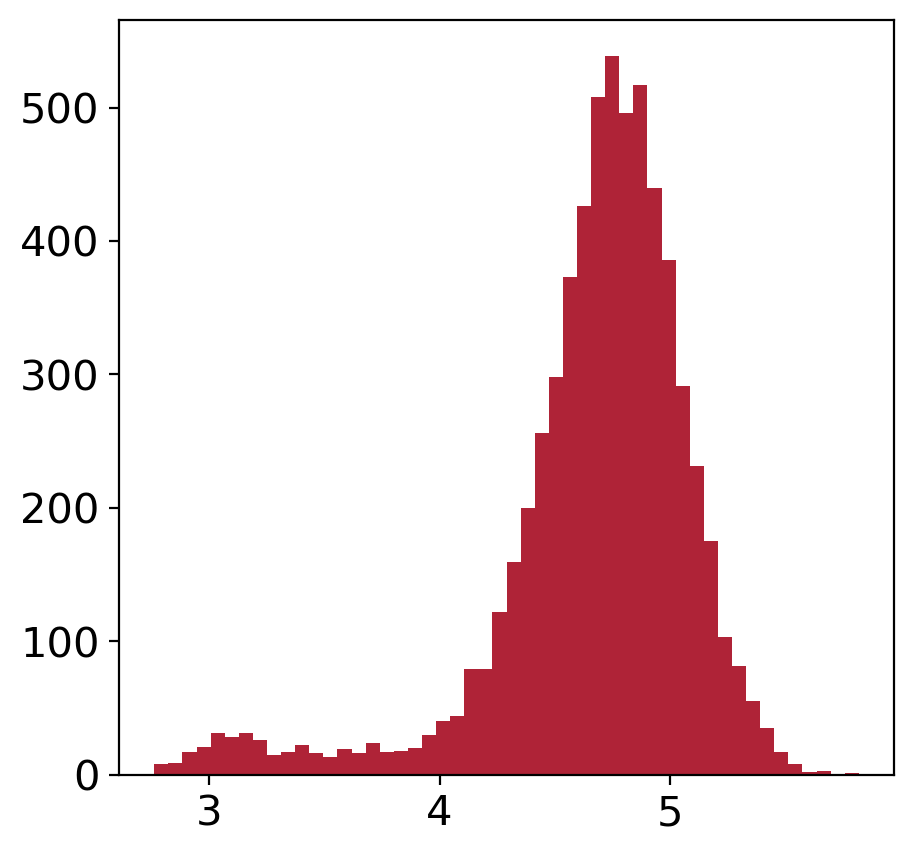

In [13]:
plt.figure(figsize=(5,5))
plt.hist(np.log10(df_rna['total']), 50)
plt.show()

In [14]:
df_rna['species'] = 0
df_rna.loc[df_rna['count_hs']/df_rna['total'] > 0.8, 'species'] = 'Human'
df_rna.loc[df_rna['count_mm']/df_rna['total'] > 0.8, 'species'] = 'Mouse'
df_rna.loc[df_rna.query('total < 3162').index, 'species'] = 'Low yield'
df_rna.replace({'species' : {0 : 'Mix'}}, inplace=True)

In [15]:
df_rna.species.value_counts()

Mouse        3068
Human        2563
Mix           489
Low yield     242
Name: species, dtype: int64

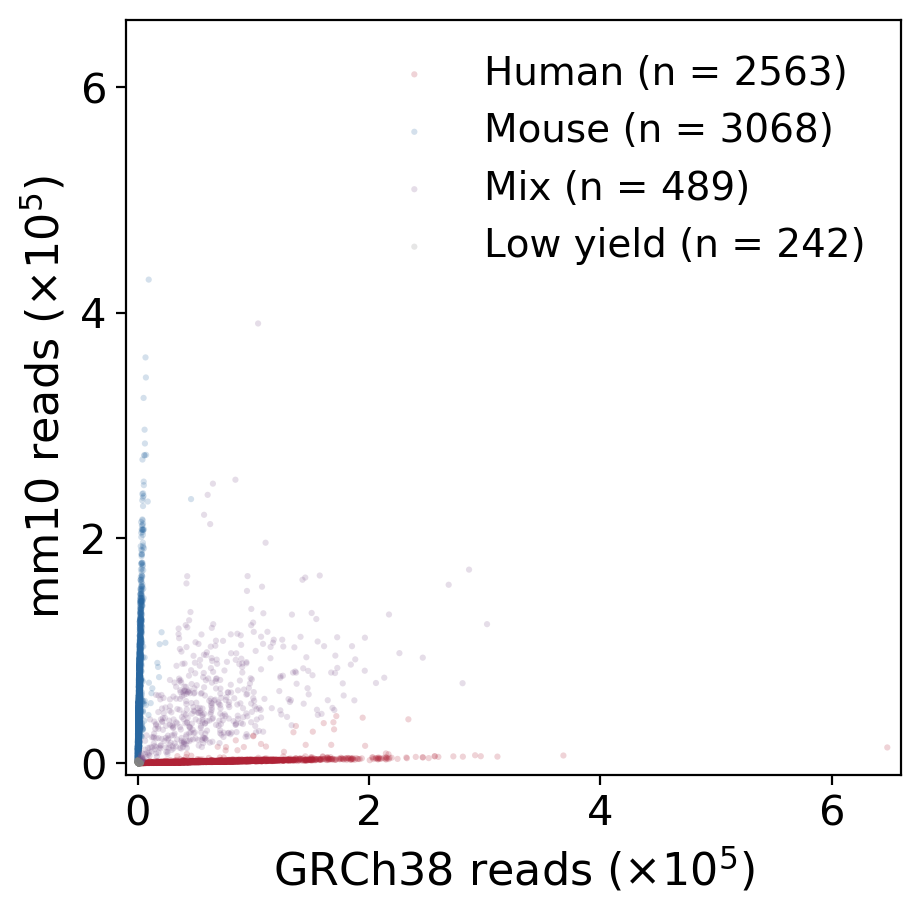

In [16]:
plt.figure(figsize=(5,5))
for sp, c in zip(['Human', 'Mouse', 'Mix', 'Low yield'], ['#af2337', '#2967a0', '#80598f', '#848482']):
    plt.scatter(df_rna.query('species == @sp')['count_hs'], df_rna.query('species == @sp')['count_mm'],
                c=c, ec=None, s=5, label='%s (n = %s)' % (sp, df_rna.species.value_counts()[sp]), alpha=.2)
plt.legend(frameon=False, markerscale=1)
plt.xlim(-10000, 660000)
plt.ylim(-10000, 660000)
plt.xticks([0, 200000, 400000, 600000], ['0', '2', '4', '6'])
plt.yticks([0, 200000, 400000, 600000], ['0', '2', '4', '6'])
plt.xlabel(r'GRCh38 reads ($\times 10^5$)')
plt.ylabel(r'mm10 reads ($\times 10^5$)')
plt.savefig('barnyard_droplet_rna_full.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
count = mmread('RNA/full_analysis/outs/Solo.out/Gene/filtered/matrix.mtx')
cols = [i.strip() for i in open('RNA/full_analysis/outs/Solo.out/Gene/filtered/barcodes.tsv')]

sc_count = pd.DataFrame(data=count.toarray(),
                        columns=cols)

In [ ]:
nih = sc_count.loc[:, df.query('species == "Mouse"').index]
hek = sc_count.loc[:, df.query('species == "Human"').index]

In [ ]:
!mkdir -p RNA/full_analysis/outs/HEK293T
!mkdir -p RNA/full_analysis/outs/NIH3T3

for cm, ct in zip([hek, nih], ['HEK293T', 'NIH3T3']):
    metrics = pd.DataFrame(data = cm.sum(0), columns = ['nCounts'])
    metrics['nFeatures'] = (cm > 0).sum(0)
    metrics.to_csv('RNA/full_analysis/outs/%s/metrics.csv' % ct, index_label='cell')

# Joint

In [17]:
df_atac.head(2)

,count_hs,count_mm,total,species
AAACAACGAACAGGCA,228.0,33073.0,33301.0,Mouse
AAACAACGAGGCCATC,26512.0,262.0,26774.0,Human


In [18]:
df_rna.head(2)

,count_hs,count_mm,total,species
AAACAACGAACAGGCA,3781.0,211103.0,214884.0,Mouse
AAACAACGAGGCCATC,134426.0,3082.0,137508.0,Human


In [19]:
df_joint = pd.merge(df_atac, df_rna, how = 'inner', left_index = True, right_index = True, suffixes = ('_atac', '_rna'))
df_joint.head()

,count_hs_atac,count_mm_atac,total_atac,species_atac,count_hs_rna,count_mm_rna,total_rna,species_rna
AAACAACGAACAGGCA,228.0,33073.0,33301.0,Mouse,3781.0,211103.0,214884.0,Mouse
AAACAACGAGGCCATC,26512.0,262.0,26774.0,Human,134426.0,3082.0,137508.0,Human
AAACAACGATAATGCC,17035.0,206.0,17241.0,Human,87336.0,3066.0,90402.0,Human
AAACAACGATGCACCG,122.0,26418.0,26540.0,Mouse,2177.0,68480.0,70657.0,Mouse
AAACACGCTAATGCGG,27.0,3845.0,3872.0,Mouse,536.0,9438.0,9974.0,Mouse


In [20]:
df_joint.shape

(6115, 8)

In [21]:
df_joint['ATAC GRCh38 fragments %'] = df_joint['count_hs_atac']/df_joint['total_atac'] * 100
df_joint['RNA GRCh38 reads %'] = df_joint['count_hs_rna']/df_joint['total_rna'] * 100

In [22]:
df_joint['species_joint'] = df_joint['species_atac'] + df_joint['species_rna']
df_joint.head()

,count_hs_atac,count_mm_atac,total_atac,species_atac,count_hs_rna,count_mm_rna,total_rna,species_rna,ATAC GRCh38 fragments %,RNA GRCh38 reads %,species_joint
AAACAACGAACAGGCA,228.0,33073.0,33301.0,Mouse,3781.0,211103.0,214884.0,Mouse,0.684664,1.759554,MouseMouse
AAACAACGAGGCCATC,26512.0,262.0,26774.0,Human,134426.0,3082.0,137508.0,Human,99.021439,97.758676,HumanHuman
AAACAACGATAATGCC,17035.0,206.0,17241.0,Human,87336.0,3066.0,90402.0,Human,98.805174,96.608482,HumanHuman
AAACAACGATGCACCG,122.0,26418.0,26540.0,Mouse,2177.0,68480.0,70657.0,Mouse,0.459683,3.081082,MouseMouse
AAACACGCTAATGCGG,27.0,3845.0,3872.0,Mouse,536.0,9438.0,9974.0,Mouse,0.697314,5.373972,MouseMouse


In [23]:
df_joint.replace({'species_joint' : {
                                        'HumanHuman'     : 'Human',
                                        'HumanMouse'     : 'Mix',
                                        'HumanMix'       : 'Mix',
                                        'HumanLow yield' : 'Low yield',
                                        'MouseHuman'     : 'Mix',
                                        'MouseMouse'     : 'Mouse',
                                        'MouseMix'       : 'Mix',
                                        'MouseLow yield' : 'Low yield',
                                        'MixHuman'     : 'Mix',
                                        'MixMouse'     : 'Mix',
                                        'MixMix'       : 'Mix',
                                        'MixLow yield' : 'Mix',
                                        'Low yieldHuman'     : 'Low yield',
                                        'Low yieldMouse'     : 'Low yield',
                                        'Low yieldMix'       : 'Low yield',
                                        'Low yieldLow yield' : 'Low yield',
                                    }
                 },
                 inplace = True)
df_joint['species_joint'].value_counts()

Mouse        3011
Human        2485
Mix           526
Low yield      93
Name: species_joint, dtype: int64

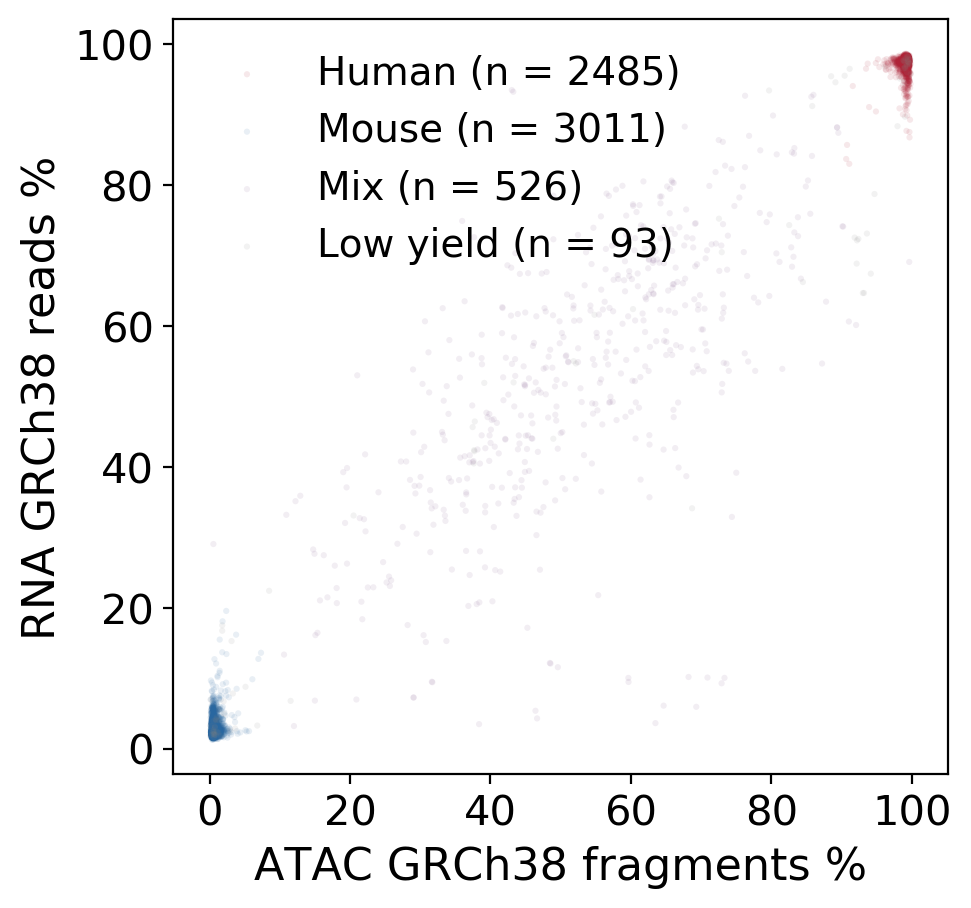

In [29]:
plt.figure(figsize=(5,5))
for sp, c in zip(['Human', 'Mouse', 'Mix', 'Low yield'], ['#af2337', '#2967a0', '#80598f', '#848482']):
    plt.scatter(df_joint.query('species_joint == @sp')['ATAC GRCh38 fragments %'],
                df_joint.query('species_joint == @sp')['RNA GRCh38 reads %'], ec=None,
                c=c, s=5, label='%s (n = %s)' % (sp, df_joint.species_joint.value_counts()[sp]), alpha=.1)
plt.legend(frameon=False, markerscale=1, loc='upper left')
plt.xlabel(r'ATAC GRCh38 fragments %')
plt.ylabel(r'RNA GRCh38 reads %')
plt.savefig('barnyard_droplet_joint_full.pdf', bbox_inches='tight', transparent=True)
plt.show()